# Visualisation des données SoDa (_merge_ des mesures _in situ_ et de réanalyse, prises comme données locales)

## _Data engineering_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import tensorflow as tf

### Columns

| Name | Unit | Description |
| :----: | :----: | :----: |
| Irradiation | $Wh \cdot m^{-2}$ | Irradiation over the period (-999 if no data)
| Clear-Sky | $Wh \cdot m^{-2}$ | Irradiation over the period if the sky were clear
| Top of Atmosphere | $Wh \cdot m^{-2}$ | Irradiation over the period at the top of the atmosphere (extraterrestrial)
| Temperature | $K$ | Temperature at 2 m above ground
| Relative humidity | % | Relative humidity at 2 m above ground
| Pressure | $hPa$ | Pressure at ground level
| Wind speed | $m \cdot s^{-1}$ | Wind speed at 10 m above ground
| Wind direction | ° | Wind direction at 10 m above ground (0 means from North, 90 from East)
| Rainfall | $kg \cdot m^{-2}$ | Rainfall (rain depth in mm)
| Snowfall | $kg \cdot m^{-2}$ | Snowfall
| Snow depth | $m$ | Snow depth

Code
| 0 | 1 | 2 | 5 | 6 |
| :--: | :--: | :--: | :--: | :--: |
|no data | sun below horizon | satellite assessment | interpolation in time | forecast |

In [2]:
database = pd.read_csv(
    '../Data/SoDa_buoy.csv',
    sep=';',
    comment='#',
    usecols=['Date', 'Time', 'Global Horiz', 'Clear-Sky', 'Code', 'Temperature', 'Wind speed', 'Wind direction']
)
database

,Date,Time,Global Horiz,Clear-Sky,Code,Temperature,Wind speed,Wind direction
0,2010-01-01,01:00,0,0,1,285.91,4.65,228.23
1,2010-01-01,02:00,0,0,1,285.81,4.61,220.38
2,2010-01-01,03:00,0,0,1,285.74,4.76,212.95
3,2010-01-01,04:00,0,0,1,285.64,5.04,205.75
4,2010-01-01,05:00,0,0,1,285.54,5.37,203.12
...,...,...,...,...,...,...,...,...
105187,2021-12-31,20:00,0,0,1,285.68,3.39,211.05
105188,2021-12-31,21:00,0,0,1,285.50,3.38,209.23
105189,2021-12-31,22:00,0,0,1,285.59,3.37,211.12
105190,2021-12-31,23:00,0,0,1,285.77,3.23,208.88


### Vérification de la structure

In [3]:
hours = np.array(database['Time'], dtype='str')
hours

array(['00:15', '00:30', '00:45', ..., '23:30', '23:45', '24:00'],
      dtype='<U5')

In [4]:
np.char.endswith(hours[::4], '15').all() and np.char.endswith(hours[1::4], '30').all() and \
np.char.endswith(hours[2::4], '45').all() and np.char.endswith(hours[3::4], '00').all()

True

On va donc pouvoir moyenner sans problème : on a bien pour chaque heure les $4$ valeurs.

In [5]:
database['Code'].value_counts()

1    205281
2    167685
5     47802
Name: Code, dtype: int64

### Mise en forme

In [6]:
data = database.to_numpy()
rows, _ = data.shape
newshape = (rows // 4, 4)

date = np.array([l for l in np.char.split(data[::4, 0].astype(np.str), sep='-')], dtype=np.int)

df = pd.DataFrame()
df['Year'] = date[:, 0]
df['Month'] = date[:, 1]
df['Day'] = date[:, 2]
df['Hour'] = np.array([h.split(':')[0] for h in data[3::4, 1]], dtype=np.int)
df['GHI'] = data[:, 2].reshape(newshape).astype(np.float).sum(axis=1)
df['CS'] = data[:, 3].reshape(newshape).astype(np.float).sum(axis=1)
df['T'] = data[:, 5].reshape(newshape).astype(np.float).mean(axis=1)
df['P'] = data[:, 6].reshape(newshape).astype(np.float).mean(axis=1)
df['WS'] = data[:, 7].reshape(newshape).astype(np.float).mean(axis=1)
df['WD'] = data[:, 8].reshape(newshape).astype(np.float).mean(axis=1)

In [7]:
df

,Year,Month,Day,Hour,GHI,CS,T,P,WS,WD
0,2010,1,1,1,0.0,0.0,280.9750,938.0050,1.4300,216.0875
1,2010,1,1,2,0.0,0.0,280.8525,937.3225,1.5800,196.1225
2,2010,1,1,3,0.0,0.0,280.8525,936.4600,1.9150,185.5050
3,2010,1,1,4,0.0,0.0,280.7975,935.5300,2.2725,176.0000
4,2010,1,1,5,0.0,0.0,280.7125,934.6600,2.5025,168.8875
...,...,...,...,...,...,...,...,...,...,...
105187,2021,12,31,20,0.0,0.0,284.7500,999.4550,0.6875,21.6675
105188,2021,12,31,21,0.0,0.0,284.5550,999.5950,0.7750,260.8025
105189,2021,12,31,22,0.0,0.0,284.3850,999.4725,0.8050,347.6275
105190,2021,12,31,23,0.0,0.0,284.2375,999.1850,0.7550,178.9500


## Data viz

In [8]:
cropped = pd.DataFrame(df.loc[df['CS'] >= 5, :])
cropped

,Year,Month,Day,Hour,GHI,CS,T,P,WS,WD
7,2010,1,1,8,8.7893,29.9059,280.3375,933.5475,0.6150,302.2575
8,2010,1,1,9,55.3954,152.7502,280.2825,933.9550,2.2575,349.1625
9,2010,1,1,10,149.9530,274.7714,280.4100,934.5775,3.2400,340.5800
10,2010,1,1,11,122.3127,356.2629,280.9225,935.0675,3.5925,326.4125
11,2010,1,1,12,128.9017,387.1745,281.5125,935.4050,3.8350,308.1400
...,...,...,...,...,...,...,...,...,...,...
105179,2021,12,31,12,238.7663,389.4735,287.8175,998.3625,1.2700,167.3975
105180,2021,12,31,13,161.3860,364.8255,287.6900,998.2025,1.3850,159.0525
105181,2021,12,31,14,147.1752,287.9532,287.3000,998.0200,1.3000,144.9950
105182,2021,12,31,15,83.2536,169.9954,286.9125,997.8325,1.3075,130.0900


In [9]:
cropped['Kc'] = cropped.loc[df['CS'] >= 5, 'GHI']/cropped.loc[df['CS'] >= 5, 'CS']
cropped['Kc']

7         0.293899
8         0.362654
9         0.545737
10        0.343321
11        0.332929
            ...   
105179    0.613049
105180    0.442365
105181    0.511108
105182    0.489740
105183    0.436622
Name: Kc, Length: 53704, dtype: float64

In [10]:
cropped.groupby(['Year', 'Month', 'Day']).mean()

Hour         GHI          CS           T           P  \
Year Month Day                                                         
2010 1     1    12.0   94.968033  230.360222  281.101389  935.522500   
           2    12.0  232.863400  259.243200  279.367778  953.032778   
           3    12.0  144.488467  244.005922  277.818056  964.321111   
           4    12.0  114.445578  235.563244  276.690278  958.348889   
           5    12.0   87.413911  237.759756  276.529444  947.291111   
...              ...         ...         ...         ...         ...   
2021 12    27   12.0   79.712289  223.940756  283.275278  980.319722   
           28   12.0  173.242867  230.288344  283.960556  981.062222   
           29   12.0  185.449189  227.922678  285.993333  983.313333   
           30   12.0  171.468333  227.048367  287.186389  992.422222   
           31   12.0  135.030811  231.262667  287.129167  998.231111   

                      WS          WD        Kc  
Year Month Day                                  
2010 1     1    3.428611  304.356667  0.413217  
           2    7.083333  299.193333  0.850885  
           3    2.572500  135.223056  0.554630  
           4    6.398333   55.011944  0.488502  
           5    6.500556   40.997222  0.383574  
...                  ...         ...       ...  
2021 12    27   1.741389  209.329167  0.371757  
           28   1.854444   78.022222  0.693811  
           29   1.152222  192.914167  0.780861  
           30   0.702778  200.480278  0.729955  
           31   0.915278  192.414722  0.574317  

[4383 rows x 8 columns]

In [11]:
Kc = cropped.groupby(['Year', 'Month']).mean()['Kc']
Kc

Year  Month
2010  1        0.620897
      2        0.617676
      3        0.665861
      4        0.771505
      5        0.744787
                 ...   
2021  8        0.810471
      9        0.773821
      10       0.706259
      11       0.630206
      12       0.680487
Name: Kc, Length: 144, dtype: float64

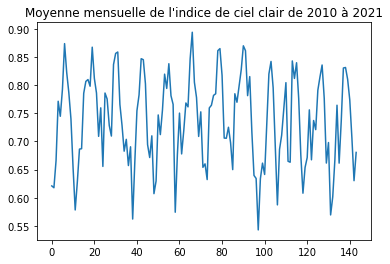

In [12]:
plt.plot(np.arange(Kc.size), Kc)
plt.title("Moyenne mensuelle de l'indice de ciel clair de 2010 à 2021");

On observe une certaine perdiocité (de période $1$ an). On peut comparer mois par mois.

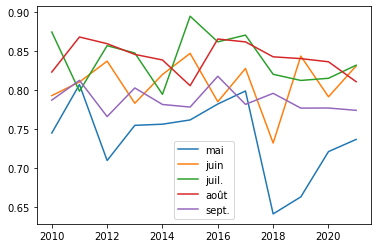

In [13]:
# %matplotlib auto

plt.figure()
monthNames = ['janv.', 'fev.', 'mars', 'avr.', 'mai', 'juin', 'juil.', 'août', 'sept.', 'oct.', 'nov.', 'dec.']
T = np.arange(2010, 2022)
for k in range(5, 10):
    KcByMonth = cropped.loc[cropped['Month'] == k, :].groupby('Year')['Kc'].mean()
    plt.plot(T, KcByMonth, label=monthNames[k - 1])
plt.legend();

In [14]:
# %matplotlib inline

## Dumb predictor

On attribue (quand c'est possible) à un $K_c$ à l'heure $t$ la valeur mesurée à $t - 1$. Cette prédiction a d'une part des performances assez surprenante et constitue un premier objectif à dépasser.

In [15]:
# First Kc Available in the day
# Last Kc Available in the day

cropped = cropped.join(
    cropped.groupby(['Year', 'Month', 'Day']).min()['Hour'],
    on=['Year', 'Month', 'Day'],
    rsuffix='Fst'
)
cropped = cropped.join(
    cropped.groupby(['Year', 'Month', 'Day']).max()['Hour'],
    on=['Year', 'Month', 'Day'],
    rsuffix='Lst'
)
cropped

,Year,Month,Day,Hour,GHI,CS,T,P,WS,WD,Kc,HourFst,HourLst
7,2010,1,1,8,8.7893,29.9059,280.3375,933.5475,0.6150,302.2575,0.293899,8,16
8,2010,1,1,9,55.3954,152.7502,280.2825,933.9550,2.2575,349.1625,0.362654,8,16
9,2010,1,1,10,149.9530,274.7714,280.4100,934.5775,3.2400,340.5800,0.545737,8,16
10,2010,1,1,11,122.3127,356.2629,280.9225,935.0675,3.5925,326.4125,0.343321,8,16
11,2010,1,1,12,128.9017,387.1745,281.5125,935.4050,3.8350,308.1400,0.332929,8,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105179,2021,12,31,12,238.7663,389.4735,287.8175,998.3625,1.2700,167.3975,0.613049,8,16
105180,2021,12,31,13,161.3860,364.8255,287.6900,998.2025,1.3850,159.0525,0.442365,8,16
105181,2021,12,31,14,147.1752,287.9532,287.3000,998.0200,1.3000,144.9950,0.511108,8,16
105182,2021,12,31,15,83.2536,169.9954,286.9125,997.8325,1.3075,130.0900,0.489740,8,16


In [16]:
cropped['HourFst'].value_counts()

5    19851
6    14052
7    10566
8     9235
Name: HourFst, dtype: int64

In [17]:
# Number of hours for which the Kc is available

cropped['HourFor'] = cropped['Hour'] - cropped['HourFst']
cropped

,Year,Month,Day,Hour,GHI,CS,T,P,WS,WD,Kc,HourFst,HourLst,HourFor
7,2010,1,1,8,8.7893,29.9059,280.3375,933.5475,0.6150,302.2575,0.293899,8,16,0
8,2010,1,1,9,55.3954,152.7502,280.2825,933.9550,2.2575,349.1625,0.362654,8,16,1
9,2010,1,1,10,149.9530,274.7714,280.4100,934.5775,3.2400,340.5800,0.545737,8,16,2
10,2010,1,1,11,122.3127,356.2629,280.9225,935.0675,3.5925,326.4125,0.343321,8,16,3
11,2010,1,1,12,128.9017,387.1745,281.5125,935.4050,3.8350,308.1400,0.332929,8,16,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105179,2021,12,31,12,238.7663,389.4735,287.8175,998.3625,1.2700,167.3975,0.613049,8,16,4
105180,2021,12,31,13,161.3860,364.8255,287.6900,998.2025,1.3850,159.0525,0.442365,8,16,5
105181,2021,12,31,14,147.1752,287.9532,287.3000,998.0200,1.3000,144.9950,0.511108,8,16,6
105182,2021,12,31,15,83.2536,169.9954,286.9125,997.8325,1.3075,130.0900,0.489740,8,16,7


In [18]:
cropped['HourFor'].value_counts()

0     4383
1     4383
2     4383
3     4383
4     4383
5     4383
6     4383
7     4383
8     4383
9     3638
10    3097
11    2587
12    2233
13    1401
14    1301
Name: HourFor, dtype: int64

In [19]:
labels = cropped.loc[cropped['HourFor'] > 0, :]
labels

,Year,Month,Day,Hour,GHI,CS,T,P,WS,WD,Kc,HourFst,HourLst,HourFor
8,2010,1,1,9,55.3954,152.7502,280.2825,933.9550,2.2575,349.1625,0.362654,8,16,1
9,2010,1,1,10,149.9530,274.7714,280.4100,934.5775,3.2400,340.5800,0.545737,8,16,2
10,2010,1,1,11,122.3127,356.2629,280.9225,935.0675,3.5925,326.4125,0.343321,8,16,3
11,2010,1,1,12,128.9017,387.1745,281.5125,935.4050,3.8350,308.1400,0.332929,8,16,4
12,2010,1,1,13,148.1492,364.1487,281.8925,935.8450,3.9800,293.2900,0.406837,8,16,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105179,2021,12,31,12,238.7663,389.4735,287.8175,998.3625,1.2700,167.3975,0.613049,8,16,4
105180,2021,12,31,13,161.3860,364.8255,287.6900,998.2025,1.3850,159.0525,0.442365,8,16,5
105181,2021,12,31,14,147.1752,287.9532,287.3000,998.0200,1.3000,144.9950,0.511108,8,16,6
105182,2021,12,31,15,83.2536,169.9954,286.9125,997.8325,1.3075,130.0900,0.489740,8,16,7


In [20]:
X = cropped.loc[labels.index - 1, :]
X

,Year,Month,Day,Hour,GHI,CS,T,P,WS,WD,Kc,HourFst,HourLst,HourFor
7,2010,1,1,8,8.7893,29.9059,280.3375,933.5475,0.6150,302.2575,0.293899,8,16,0
8,2010,1,1,9,55.3954,152.7502,280.2825,933.9550,2.2575,349.1625,0.362654,8,16,1
9,2010,1,1,10,149.9530,274.7714,280.4100,934.5775,3.2400,340.5800,0.545737,8,16,2
10,2010,1,1,11,122.3127,356.2629,280.9225,935.0675,3.5925,326.4125,0.343321,8,16,3
11,2010,1,1,12,128.9017,387.1745,281.5125,935.4050,3.8350,308.1400,0.332929,8,16,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105178,2021,12,31,11,237.5367,359.1496,287.5100,998.4750,0.7400,170.1300,0.661387,8,16,3
105179,2021,12,31,12,238.7663,389.4735,287.8175,998.3625,1.2700,167.3975,0.613049,8,16,4
105180,2021,12,31,13,161.3860,364.8255,287.6900,998.2025,1.3850,159.0525,0.442365,8,16,5
105181,2021,12,31,14,147.1752,287.9532,287.3000,998.0200,1.3000,144.9950,0.511108,8,16,6


In [21]:
assertion = (np.array(X['Year']) == np.array(labels['Year'])) & \
    (np.array(X['Month']) == np.array(labels['Month'])) & \
    (np.array(X['Day']) == np.array(labels['Day'])) & \
    (np.array(X['Hour']) == np.array(labels['Hour'] - 1))
assertion.all()

True

In [22]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_true=labels['Kc'], y_pred=X['Kc'], squared=False)
print(f"Dumb predictor's RMSE : {RMSE}")

Dumb predictor's RMSE : 0.12100835338876774


## Auto-regression

Régression linéaire visant à prédire $GHI_t$ avec les features $GHI_{t - i}$ pour $1 \leqslant i \leqslant p$.

In [23]:
y = cropped.loc[cropped['HourFor'] > 2, 'Kc']
X = np.array(
    [cropped.loc[y.index - 1, 'Kc'], cropped.loc[y.index - 2, 'Kc'], cropped.loc[y.index - 3, 'Kc']]
).T
X.shape

(40555, 3)

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred, squared=False)
print(f"Auto-regression RMSE : {RMSE}")

Auto-regression RMSE : 0.11461426041816879


## Auto-regression integrating $T$ and $P$

In [25]:
y = cropped.loc[cropped['HourFor'] > 2, 'Kc']
X = np.array([
    cropped.loc[y.index - 1, 'Kc'],
    cropped.loc[y.index - 2, 'Kc'], 
    cropped.loc[y.index - 3, 'Kc'],
    cropped.loc[y.index - 1, 'T'],
    cropped.loc[y.index - 1, 'P']
]).T
X.shape

(40555, 5)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred, squared=False)
print(f"Exogeneous auto-regression RMSE : {RMSE}")

Exogeneous auto-regression RMSE : 0.11097753774484158


## Same with only May to Septembre months

In [27]:
-.2 <= np.random.randn(15)

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
       False, False,  True,  True,  True,  True])

In [28]:
cropped = pd.DataFrame(cropped.loc[(4 < cropped['Month']) & (cropped['Month'] < 10), :])
cropped

,Year,Month,Day,Hour,GHI,CS,T,P,WS,WD,Kc,HourFst,HourLst,HourFor
2884,2010,5,1,5,7.0837,10.4050,285.5400,960.5125,0.7650,272.5275,0.680798,5,19,0
2885,2010,5,1,6,95.2659,116.7004,286.2750,960.5950,0.5050,310.7225,0.816329,5,19,1
2886,2010,5,1,7,244.5407,293.0673,287.3925,960.7600,0.3225,295.6875,0.834418,5,19,2
2887,2010,5,1,8,442.4723,480.5729,288.2825,960.9000,0.4025,206.2300,0.920718,5,19,3
2888,2010,5,1,9,633.4423,648.2266,289.0075,960.9725,0.8625,167.5850,0.977193,5,19,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102972,2021,9,30,13,601.7906,659.2308,296.2350,969.2450,3.7475,86.0800,0.912868,6,17,7
102973,2021,9,30,14,534.8215,563.5403,296.1125,968.9075,3.5800,94.6925,0.949039,6,17,8
102974,2021,9,30,15,397.5187,420.5494,295.7375,968.6675,3.2950,102.0100,0.945237,6,17,9
102975,2021,9,30,16,215.8210,245.1790,295.0875,968.4800,2.8425,106.0975,0.880259,6,17,10


### _Dump predictor_

In [29]:
y = cropped.loc[cropped['HourFor'] > 0, 'Kc']
pred = cropped.loc[y.index - 1, 'Kc']

mean_squared_error(y, pred, squared=False)

0.1284566380726356

### Auto-regression

In [30]:
y = cropped.loc[cropped['HourFor'] > 2, 'Kc']
X = np.array([
    cropped.loc[y.index - 1, 'Kc'],
    cropped.loc[y.index - 2, 'Kc'], 
    cropped.loc[y.index - 3, 'Kc']
]).T
X.shape

(20841, 3)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred, squared=False)
print(f"Monthly specific auto-regression RMSE : {RMSE}")

Monthly specific auto-regression RMSE : 0.12040902470016877


## Multi-layer perceptron